In [1]:
from tensorflow import keras

from tensorflow.keras import models, layers #type:ignore
 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

from tqdm import tqdm
import matplotlib.pyplot as plt 
import numpy as np 

In [2]:
# Preparing the dataset and creating the features and target arrays

n_sims = 10000

x = []
y = []

for i in tqdm(range(n_sims), desc='Carregando dados', ascii=True):
    data = np.load(f'../input47/data_{i+1}.npy')
    x.append(data[:, :2])
    y.append(data[0, 2])  # equivalente a data[:, 2:][0][0]

x = np.array(x)
y = np.array(y)

norm = y.max()
# Normalização
# y /= y.max()


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25)

Carregando dados: 100%|##########| 10000/10000 [00:01<00:00, 5712.67it/s]


In [44]:
# early_stopping = keras.callbacks.EarlyStopping(
#     min_delta=0.0001, # minimium amount of change to count as an improvement
#     patience=5, # how many epochs to wait before stopping
#     restore_best_weights=True,
# )

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',   
    patience=3,          
    verbose=1,          
    factor=0.5,          
    min_lr=0.00001,
    min_delta=0.001       
)

# learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=0.01,  # Initial learning rate for training
#     decay_steps=100,            # Number of steps before decaying the learning rate
#     decay_rate=0.5,              # Rate at which the learning rate decreases
# )

# lr_callback = keras.callbacks.LearningRateScheduler(learning_rate_schedule)


In [55]:
# defining the model

model = models.Sequential()

model.add(layers.Flatten())


model.add(layers.Dense(16, activation='relu'))

# model.add(layers.Dense(16, activation='relu'))

model.add(layers.Dense(1))

model.compile(loss=keras.losses.MeanSquaredError(), optimizer='nadam', metrics=keras.metrics.MeanAbsoluteError())


history = model.fit(x_train, y_train, validation_split=.2, epochs=25, batch_size=8, verbose=1, callbacks=[reduce_lr])

Epoch 1/25
750/750 [==============================] - 5s 6ms/step - loss: 214.8437 - mean_absolute_error: 2.6119 - val_loss: 0.2887 - val_mean_absolute_error: 0.4573 - lr: 0.0010
Epoch 2/25
750/750 [==============================] - 4s 5ms/step - loss: 0.2835 - mean_absolute_error: 0.4504 - val_loss: 0.3456 - val_mean_absolute_error: 0.4842 - lr: 0.0010
Epoch 3/25
750/750 [==============================] - 4s 5ms/step - loss: 0.2996 - mean_absolute_error: 0.4580 - val_loss: 0.2435 - val_mean_absolute_error: 0.4244 - lr: 0.0010
Epoch 4/25
750/750 [==============================] - 4s 6ms/step - loss: 0.3417 - mean_absolute_error: 0.4806 - val_loss: 0.4939 - val_mean_absolute_error: 0.5695 - lr: 0.0010
Epoch 5/25
750/750 [==============================] - 4s 6ms/step - loss: 2.9313 - mean_absolute_error: 1.2083 - val_loss: 1.6372 - val_mean_absolute_error: 1.2091 - lr: 0.0010
Epoch 6/25
744/750 [============================>.] - ETA: 0s - loss: 4.5191 - mean_absolute_error: 1.7254
Epoch 

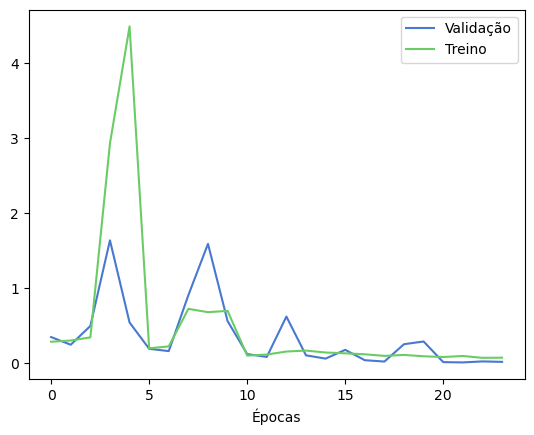

In [56]:
plt.plot(history.history['val_loss'][1:], label='Validação')
plt.plot(history.history['loss'][1:], label='Treino')


plt.xlabel('Épocas')
plt.legend()


# plt.savefig("imagens/loss_h0_dense")

plt.show()

In [57]:
y_pred = model.predict(x_test)


r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

mse

79/79 [==============================] - 0s 2ms/step


0.01513455046578839

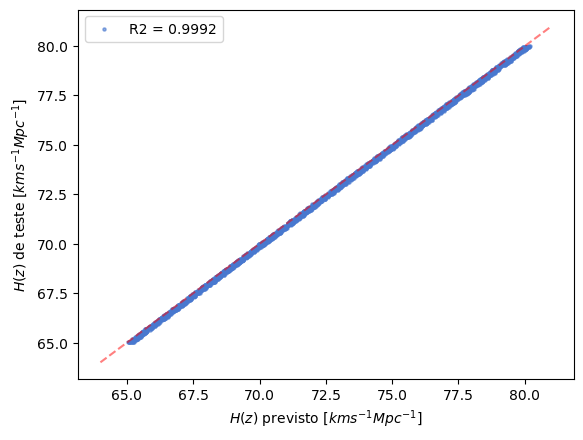

In [58]:
plt.style.use('seaborn-v0_8-muted')

linha = np.linspace(64, 81)
# linha = np.linspace(.28, .35, 2500)


# plt.scatter(y_pred*norm, y_test*norm, s=5, alpha=.6, label=f'R2 = {r2:.4f}')
plt.scatter(y_pred, y_test, s=5, alpha=.6, label=f'R2 = {r2:.4f}')
plt.plot(linha, linha, alpha=.5, c='red', ls='--')

plt.legend()


plt.xlabel(r'$H (z)$ previsto [$km s^{-1} Mpc^{-1}$] ')
plt.ylabel(r'$H (z)$ de teste [$km s^{-1} Mpc^{-1}$] ')


# plt.savefig("imagens/metrics_h0_dense")
plt.show()

In [59]:
# forecasting "real" H(0)

real = np.load('../input47/data_real47.npy')
# real = real[real[:, 1].argsort()]

real = real.reshape(-1,47,2)

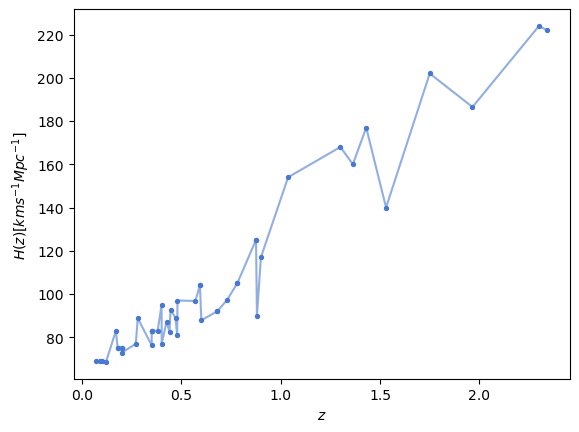

In [60]:

plt.scatter(real[:, :, 0][0], real[:, :, 1][0], s=8)
plt.plot(real[:, :, 0][0], real[:, :, 1][0], alpha=.6)

plt.xlabel(r'$z$')
plt.ylabel(r'$H (z)$[$km s^{-1} Mpc^{-1}$] ')

plt.show()

In [61]:

final_real = model.predict(real, verbose=0)

In [62]:
# final_real*norm
final_real

array([[73.201225]], dtype=float32)

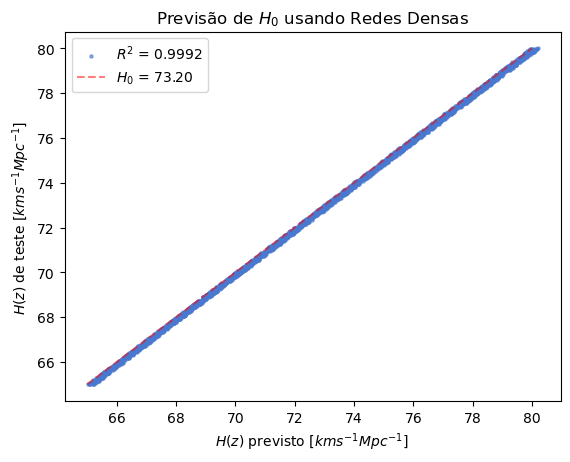

In [63]:
plt.style.use('seaborn-v0_8-muted')

# linha = np.linspace(.3, .35, 2500)
linha = np.linspace(65, 80)

plt.scatter(y_pred, y_test, s=5, alpha=.6, label=(r'$R^2$ '+ f'= {r2:.4f}'))
plt.plot(linha, linha, alpha=.5, c='red', ls='--', label=(r'$H_0$ '+ f'= {final_real[0][0]:.2f}'))

plt.legend()

plt.title('Previsão de $H_0$ usando Redes Densas')

plt.xlabel(r'$H (z)$ previsto [$km s^{-1} Mpc^{-1}$] ')
plt.ylabel(r'$H (z)$ de teste [$km s^{-1} Mpc^{-1}$] ')


# plt.savefig("../imagens/metrics_h0_rnn")
plt.show()

In [64]:
# model.save('models/dense')